### USC ID  : 8534717045
### NAME   : SRINATH BEGUDEM
### GITHUB: SrinathBegudem


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


## Text Classification

It is highly recommended that you complete this project using Keras and Python.

### (a) In this problem, we are trying to build a classifier to analyze the sentiment of reviews. You are provided with text data in two folders: one folder involves positive reviews, and one folder involves negative reviews.

### (b) Data Exploration and Pre-processing

#### 1. You can use binary encoding for the sentiments, i.e., `y = 1` for positive sentiments and `y = -1` for negative sentiments.
#### 2. The data are pretty clean. Remove the punctuation and numbers from the data.
#### 3. The name of each text file starts with `cv_number`. Use text files 0-699 in each class for training and 700-999 for testing.

In [2]:
import os
import pandas as pd
import re
import warnings
warnings.filterwarnings("ignore")

# Function to clean the text data
def clean_text(text):
    # Remove punctuation and numbers using regular expression
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Function to load data from a directory, specifying whether to load training or testing data
def load_data(directory, train=True):
    reviews = []  # List to hold the text of each review
    sentiments = []  # List to hold the sentiment label of each review
    lower_bound = 0 if train else 700
    upper_bound = 700 if train else 1000  # Adjust bounds for training/testing split

    # Loop over each file in the directory
    for filename in os.listdir(directory):
        # Extract the number from the filename: filename format is 'cvxxx_xxxxx.txt'
        num = int(filename[2:5])  # This extracts the 'xxx' part from 'cvxxx_xxxxx.txt'
        if lower_bound <= num < upper_bound:
            file_path = os.path.join(directory, filename)  # Create full path to the file
            # Open the file and read its content
            with open(file_path, 'r', encoding='utf8') as file:
                cleaned_review = clean_text(file.read())  # Clean the content of the file
                reviews.append(cleaned_review)  # Add the cleaned content to the reviews list
                # Determine sentiment based on the directory name
                sentiment = 1 if 'pos' in directory else 0
                sentiments.append(sentiment)  # Add the sentiment to the sentiments list

    return reviews, sentiments  # Return the lists of reviews and sentiments

# Set the path to the folders containing positive and negative reviews
pos_path = '../data/pos'
neg_path = '../data/neg'

# Load the training data
pos_reviews_train, pos_sentiments_train = load_data(pos_path, train=True)
neg_reviews_train, neg_sentiments_train = load_data(neg_path, train=True)

# Load the testing data
pos_reviews_test, pos_sentiments_test = load_data(pos_path, train=False)
neg_reviews_test, neg_sentiments_test = load_data(neg_path, train=False)

# Combine the lists of positive and negative reviews and their sentiments for both training and testing
reviews_train = pos_reviews_train + neg_reviews_train
sentiments_train = pos_sentiments_train + neg_sentiments_train
reviews_test = pos_reviews_test + neg_reviews_test
sentiments_test = pos_sentiments_test + neg_sentiments_test

# Create DataFrames for training and testing sets
df_train = pd.DataFrame({
    'review': reviews_train,
    'sentiment': sentiments_train
})

df_test = pd.DataFrame({
    'review': reviews_test,
    'sentiment': sentiments_test
})

# Display the first few rows to check the data
print("Training data samples:")
display(df_train)
print("\nTesting data samples:")
display(df_test)


Training data samples:


,review,sentiment
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,youve got mail works alot better than it deser...,1
3,jaws is a rare film that grabs your attention ...,1
4,moviemaking is a lot like being the general ma...,1
...,...,...
1395,house on haunted hill starring taye diggs geof...,0
1396,fit for a ghouls night out fat girl stands cas...,0
1397,marie couldnt talk paulie the parrot star of h...,0
1398,well heres a distasteful thoroughly amateurish...,0



Testing data samples:


,review,sentiment
0,let me start off by saying that leading up to ...,1
1,seen september at p m at the sony nickelodeon ...,1
2,the characters in palmetto collectively sweat ...,1
3,youve got mail is the very definition of a cut...,1
4,with the sudden liberal emergence of personal ...,1
...,...,...
595,if anything stigmata should be taken as a warn...,0
596,john boormans zardoz is a goofy cinematic deba...,0
597,the kids in the hall are an acquired taste it ...,0
598,there was a time when john carpenter was a gre...,0


## Explanation of Label Encoding and Loss Function

In the context of binary classification in neural networks, it is standard practice to use labels encoded as 0 and 1. This encoding is particularly compatible with the sigmoid activation function and the binary cross-entropy loss function used in our model. Here’s a deeper look into why this approach is adopted:

### Sigmoid Activation Function

The sigmoid function is defined mathematically as:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

This function maps any real-valued number into the (0, 1) interval, making it particularly suitable for binary classification tasks where the outputs are probabilities that the input data belong to a class (1) or not (0). 

### Binary Cross-Entropy Loss

Binary cross-entropy loss is a loss function commonly used for binary classification tasks, which is defined for true label \( y \) and predicted probability \( p \) as:

$$L(y, p) = -y \log(p) - (1 - y) \log(1 - p)$$

- When \( y = 1 \) (positive class), the loss function simplifies to \( -\log(p) \), penalizing predictions that diverge from 1.
- When \( y = 0 \) (negative class), it simplifies to \( -\log(1 - p) \), penalizing predictions that diverge from 0.

### Why Not Use -1 and 1

Using labels -1 and 1 would require a different setup, both in terms of the activation function and the loss function. Typically, labels of -1 and 1 are used with functions like the hyperbolic tangent (tanh) that maps inputs to the range [-1, 1]. However, adapting the binary cross-entropy loss to work with -1 and 1 is not straightforward and requires additional transformation steps which might complicate the model without providing clear benefits.

### Advantages of Using 0 and 1

1. **Compatibility with Sigmoid and Binary Cross-Entropy**: As explained, the sigmoid function coupled with binary cross-entropy offers a direct interpretation of the output as a probability, along with a mathematically sound method for calculating loss.
2. **Simplicity and Interpretability**: This setup allows for an intuitive interpretation where the output can be directly viewed as the probability of belonging to the positive class (label 1).
3. **Common Practice**: This is a widely adopted standard in binary classification tasks across various domains, supported by numerous frameworks and libraries, which ensures consistency and comparability of results.

In summary, using 0 and 1 for labels in conjunction with the sigmoid activation function and binary cross-entropy loss is both mathematically appropriate and practically effective for training neural networks on binary classification tasks. This approach directly addresses the need for probabilistic interpretation aligned with the typical setup of neural network libraries.


# So to conclude in the project question they asked us to use binary cross entropy so to avoid misbehaving of model we used label 0 and 1 instead of -1 and 1. please consider as it is just the label name and ultimately would not effect out prediction.

### Count the number of unique words in the whole dataset (train + test) and print it out.

In [3]:
def count_unique_words(reviews):
    unique_words = set()  # Use a set to automatically handle duplicates
    for review in reviews:
        # Split each review into words and add to the set
        unique_words.update(review.split())
    return len(unique_words)

# Combine all reviews from training and testing datasets for this analysis
all_reviews = df_train['review'].tolist() + df_test['review'].tolist()

# Count the unique words in the combined dataset
unique_word_count = count_unique_words(all_reviews)

# Print out the number of unique words
print(f"Number of unique words in the entire dataset: {unique_word_count}")


Number of unique words in the entire dataset: 46787


### Calculate the average review length and the standard deviation of review lengths. Report the results.

In [4]:
import numpy as np

# Function to calculate average and standard deviation of review lengths
def calculate_review_lengths(reviews):
    lengths = [len(review.split()) for review in reviews]  # Calculate length of each review
    average_length = np.mean(lengths)  # Calculate the average length
    std_deviation = np.std(lengths)  # Calculate the standard deviation
    return average_length, std_deviation

# Combine all reviews from training and testing datasets for this analysis
all_reviews = df_train['review'].tolist() + df_test['review'].tolist()

# Calculate the average and standard deviation of review lengths
average_length, std_deviation = calculate_review_lengths(all_reviews)

# Print out the average and standard deviation of review lengths
print(f"Average review length: {average_length:.2f} words")
print(f"Standard deviation of review lengths: {std_deviation:.2f} words")


Average review length: 644.35 words
Standard deviation of review lengths: 284.98 words


### Plot the histogram of review lengths.

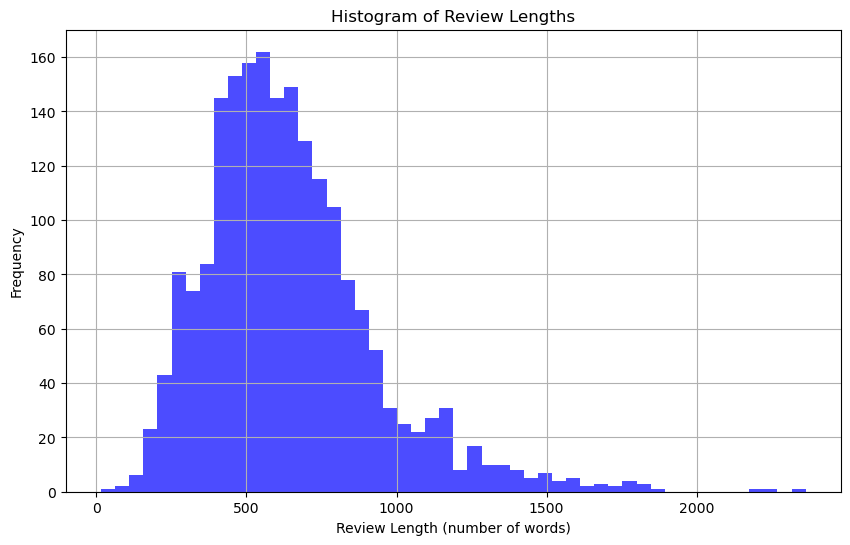

In [5]:
import matplotlib.pyplot as plt

# Function to get review lengths
def get_review_lengths(reviews):
    return [len(review.split()) for review in reviews]

# Combine all reviews from training and testing datasets for this analysis
all_reviews = df_train['review'].tolist() + df_test['review'].tolist()

# Get the lengths of all reviews
review_lengths = get_review_lengths(all_reviews)

# Plotting the histogram of review lengths
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.hist(review_lengths, bins=50, color='blue', alpha=0.7)  # Use 50 bins for the histogram
plt.title('Histogram of Review Lengths')  # Title of the histogram
plt.xlabel('Review Length (number of words)')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.grid(True)  # Show grid lines
plt.show()  # Display the histogram


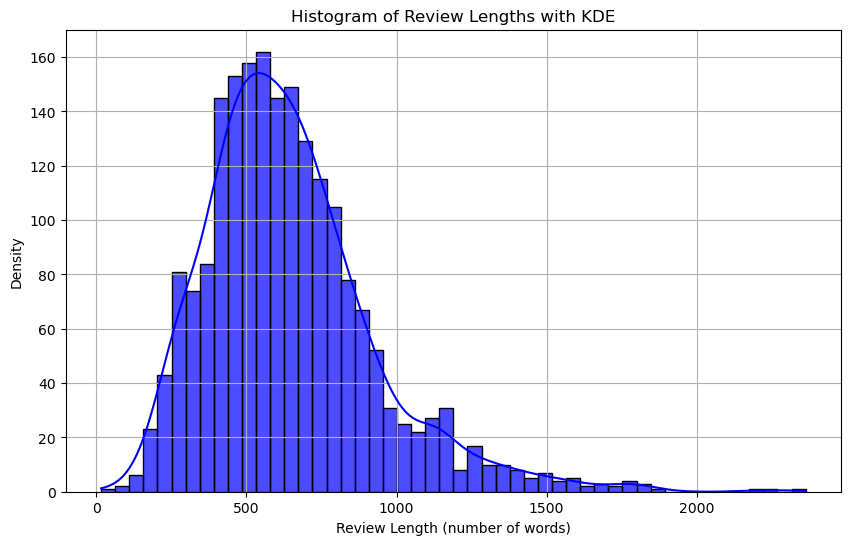

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn is used for the KDE

# Ensure seaborn is installed or install via pip if necessary
# pip install seaborn

# Function to get review lengths
def get_review_lengths(reviews):
    return [len(review.split()) for review in reviews]

# Combine all reviews from training and testing datasets for this analysis
all_reviews = df_train['review'].tolist() + df_test['review'].tolist()

# Get the lengths of all reviews
review_lengths = get_review_lengths(all_reviews)

# Plotting the histogram of review lengths with KDE
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
sns.histplot(review_lengths, bins=50, kde=True, color='blue', alpha=0.7)  # Include KDE
plt.title('Histogram of Review Lengths with KDE')  # Title of the histogram
plt.xlabel('Review Length (number of words)')  # X-axis label
plt.ylabel('Density')  # Y-axis label, changed to 'Density' because KDE is a density plot
plt.grid(True)  # Show grid lines
plt.show()  # Display the histogram


### 7. To represent each text (data point), there are many ways. In NLP/Deep Learning terminology, this task is called tokenization. It is common to represent text using popularity/rank of words in text. The most common word in the text will be represented as 1, the second most common word will be represented as 2, etc. Tokenize each text document using this method.

In [7]:
from collections import Counter
import numpy as np

# Function to count words in reviews
def count_words(reviews):
    word_counts = Counter()
    for review in reviews:
        word_counts.update(review.split())
    return word_counts

# Function to create a word-to-index mapping based on frequency
def create_word_index(word_counts):
    # Sort words by frequency (most common first)
    sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
    # Create a dictionary to map words to indices (most common has index 1)
    word_to_index = {word: idx + 1 for idx, word in enumerate(sorted_words)}
    return word_to_index

# Function to tokenize reviews based on a word-to-index mapping
def tokenize_reviews(reviews, word_to_index):
    tokenized_reviews = []
    for review in reviews:
        tokens = [word_to_index[word] if word in word_to_index else 0 for word in review.split()]
        tokenized_reviews.append(tokens)
    return tokenized_reviews

# Combine all reviews
all_reviews = df_train['review'].tolist() + df_test['review'].tolist()

# Count words across all reviews
word_counts = count_words(all_reviews)

# Create word-to-index mapping
word_to_index = create_word_index(word_counts)

# Tokenize reviews
df_train['tokenized'] = tokenize_reviews(df_train['review'], word_to_index)
df_test['tokenized'] = tokenize_reviews(df_test['review'], word_to_index)



In [8]:
# Display the first few rows of tokenized data
print("Tokenized training data samples:\n")
print(df_train['tokenized'])
print("-----------------------------------")
print("Tokenized testing data samples:\n")
print(df_test['tokenized'])

Tokenized training data samples:

0       [67, 2744, 29, 355, 1633, 32, 90, 1046, 4, 627...
1       [150, 144, 3, 102, 2, 27, 199, 264, 29, 2, 151...
2       [729, 287, 3642, 379, 9979, 153, 58, 9, 1213, ...
3       [3244, 6, 2, 1399, 15, 8, 6920, 171, 559, 142,...
4       [4788, 6, 2, 211, 39, 109, 1, 834, 3095, 4, 24...
                              ...                        
1395    [369, 19, 2435, 1421, 776, 8594, 8595, 3311, 1...
1396    [1748, 12, 2, 16786, 326, 41, 1798, 334, 1145,...
1397    [3725, 744, 626, 3267, 1, 9237, 209, 4, 13, 17...
1398    [83, 1737, 2, 14916, 1881, 7198, 7827, 8, 724,...
1399    [1096, 18, 50, 119, 120, 159, 16, 18, 243, 5, ...
Name: tokenized, Length: 1400, dtype: object
-----------------------------------
Tokenized testing data samples:

0      [464, 103, 435, 99, 21, 820, 8, 1123, 46, 5, 1...
1      [152, 8470, 30, 2388, 1610, 30, 1, 10415, 1917...
2      [1, 72, 7, 4194, 40802, 9932, 154, 5, 1977, 23...
3      [729, 287, 3642, 6, 1, 78, 5489, 4, 

### 8. Select a review length L that 70% of the reviews have a length below it. If you feel more adventurous, set the threshold to 90%.

In [9]:
# Calculate the 70th and 90th percentiles for review lengths
L_70 = np.percentile(review_lengths, 70)  # 70% of reviews are shorter than this length
L_90 = np.percentile(review_lengths, 90)  # 90% of reviews are shorter than this length

# Print the results
print(f"70% of the reviews have a length below: {int(L_70)} words")
print(f"90% of the reviews have a length below: {int(L_90)} words")

70% of the reviews have a length below: 737 words
90% of the reviews have a length below: 993 words


### 9. Truncate reviews longer than L words and zero-pad reviews shorter than L so that all texts (= data points) are of length L


In [10]:
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length
max_length = 737 

# Pad and truncate training data
X_train_padded = pad_sequences(df_train['tokenized'], maxlen=max_length, truncating='post', padding='post')

# Pad and truncate testing data
X_test_padded = pad_sequences(df_test['tokenized'], maxlen=max_length, truncating='post', padding='post')

print("Example of padded training data:")
print(X_train_padded[0])  # Display the first processed review in the training set

print("\nExample of truncated testing data:")
print(X_test_padded[0])  # Display the first processed review in the testing set


Example of padded training data:
[   67  2744    29   355  1633    32    90  1046     4   627   628   321
    40  7659   704  4782  1755    47  7257  1328   396  4948    47     1
 10837  1777  1778   148    16   140   108    89    68     2   355   405
    39    29   502   142    12  9974     9    31   853    21  1352  1802
     3   944  1511    28   878     1  3951     5     2   282   113   540
     7     1  7258   127    11     2   202   262   381     1 27327     5
   179  1802     3  1511  1881 27328     1   845     4   495     1 13222
    69    22    39   820   324  1231     6  2140     5   175     2    94
  1232     1   405    47  1548   523    51    35    65     6   111  4949
   196     3  1233   440    42     8  9265     4   181    16 20921     7
    73   637   119  6914    14    15    84     4    23  2110    51    35
    64    74   403     1   282   355   405   180    35   228   188   124
  6594  2809     7    29 11931   879  2857     3  1029  2591   333     1
  2591   620     5

In [11]:
# Assuming df_train and df_test are your training and testing DataFrames
y_train = df_train['sentiment'].values
y_test = df_test['sentiment'].values

# Verify that y_train and y_test are correctly assigned
print("Training labels:", y_train[:5])  # Print first 5 training labels
print("Testing labels:", y_test[:5])    # Print first 5 testing labels


Training labels: [1 1 1 1 1]
Testing labels: [1 1 1 1 1]


# Word Embeddings
### One can use tokenized text as inputs to a deep neural network. However, a recent breakthrough in NLP suggests that more sophisticated representations of text yield better results. These sophisticated representations are called word embeddings “Word embedding is a term used for representation of words for text analysis, typically in the form of a real-valued vector that encodes the meaning of the word such that the words that are closer in the vector space are expected to be similar in meaning.” . Most deep learning modules (including Keras) provide a convenient way to convert positive integer representations of words into a word embedding by an “Embedding layer.” The layer accepts arguments that define the mapping of words into embeddings, including the maximum number of expected words also called the vocabulary size (e.g. the largest integer value). The layer also allows you to specify the dimension for each word vector, called the “output dimension.” We would like to use a word embedding layer for this project. Assume that we are interested in the top 5,000 words. This means that in each integer sequence that represents each document, we set to zero those integers that represent words that are not among the top 5,000 words in the document. If you feel more adventurous, use all the words that appear in this corpus. Choose the length of the embedding vector for each word to be 32. Hence, each document is represented as a 32 × L matrix.

In [12]:
from keras.models import Sequential
from keras.layers import Embedding

# Define model parameters
vocab_size = 5001  # Vocabulary size
embed_dim = 32  # Dimension of the embedding vectors
max_length = 993  # Maximum length of input sequences

# Create the embedding layer
model = Sequential()
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length)

# Add the embedding layer to the model
model.add(embedding_layer)

# Explicitly build the model with the correct input shape
model.build(input_shape=(None, max_length))  # None allows for variable batch sizes

# Model summary to check the setup
model.summary()

# Access the weights of the embedding layer, which are the word embeddings
embedding_matrix = embedding_layer.get_weights()[0]

# Optionally, print or manipulate the embedding matrix
print("Shape of embedding matrix:", embedding_matrix.shape)
print("Sample embedding vector for word index 1:", embedding_matrix[1])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 993, 32)        │       160,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,032 (625.12 KB)

 Trainable params: 160,032 (625.12 KB)

 Non-trainable params: 0 (0.00 B)

Shape of embedding matrix: (5001, 32)
Sample embedding vector for word index 1: [ 4.9118027e-03 -2.1941924e-02 -2.0452524e-02 -3.6386959e-03
 -1.7177783e-02  1.0874320e-02 -2.8311348e-02 -3.2098807e-02
 -2.0430148e-02  8.9276582e-05 -1.4539160e-02 -1.1891950e-02
  1.5850235e-02 -5.5694208e-03 -4.6024695e-03  2.1740820e-02
  3.9814804e-02 -6.8586841e-03 -3.7098154e-03 -2.1924265e-03
  3.9643947e-02 -4.0147711e-02  1.5648592e-02 -1.1604667e-02
  4.1093063e-02 -3.8463451e-02 -3.0386304e-02 -2.1158569e-03
 -3.2163993e-02 -3.4996592e-02 -1.1540115e-02 -5.4690987e-04]


## Parameter Tuning for MLP, CNN, and LSTM Models

In this project, we have focused on fine-tuning the hyperparameters of our models while keeping the core architecture fixed. The primary hyperparameters we adjusted are the vocabulary sizes, maximum sequence lengths, and learning rates. This section discusses the rationale and impact of these changes on the performance of Multi-Layer Perceptron (MLP), Convolutional Neural Network (CNN), and Long Short-Term Memory (LSTM) models.

### Hyperparameters Tuned

1. **Vocabulary Sizes**: We varied the vocabulary sizes to observe the effect of different levels of linguistic information on the models' performance. A larger vocabulary size allows the model to learn more detailed features but can lead to overfitting if not properly regularized.

2. **Maximum Sequence Lengths**: Adjusting the maximum sequence lengths helps in understanding how much of the input text the models need to consider to make accurate predictions. Longer sequences capture more contextual information but increase computational complexity and may introduce more noise into the system.

3. **Learning Rates**: The learning rate is a critical parameter in the training of neural networks that can significantly affect both the speed and quality of training. Different learning rates were tested to find the optimal speed at which the models learn without overshooting or getting stuck in local minima.

### Implementation in Code

For each model type (MLP, CNN, and LSTM), we iterated over a range of values for these parameters. This was done using Python's `itertools.product` to create combinations of the three hyperparameters, ensuring comprehensive coverage and exploration of the parameter space:

- Vocabulary sizes were tested from 1001 to 46001, incremented by 5000.
- Maximum sequence lengths tested were 737 and 993, reflecting typical lengths observed in the data.
- Learning rates of 0.001 and 0.01 were chosen based on common practices in neural network training that balance fast convergence with the risk of overshooting the optimal.




# Multi-Layer Perceptron
### i. Train a MLP with three (dense) hidden layers each of which has 50 ReLUs and one output layer with a single sigmoid neuron. Use a dropout rate of 20% for the first layer and 50% for the other layers. Use ADAM optimizer and binary cross entropy loss (which is equivalent to having a softmax in the output). To avoid overfitting, just set the number of epochs as 2. Use a batch size of 10.
### ii. Report the train and test accuracies of this model.

In [13]:
import numpy as np
import tensorflow as tf
from itertools import product
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters to iterate over
vocab_sizes = range(1001, 46502, 5000)  # Vocab sizes from 1001 to 46001, stepping by 5000
max_lengths = [737, 993]  # Two different maximum lengths to test
learning_rates = [0.001, 0.01]  # Different learning rates to test
batch_size = 10  # Consistent batch size for training
epochs = 2  # Fixed number of epochs as per the requirement
embed_dim = 32  # Embedding dimensions

# Initialize result storage
results = []

# Experiment with each combination of parameters
for vocab_size, max_length, lr in product(vocab_sizes, max_lengths, learning_rates):
    print("---------------------------------------------------------------------------------")
    print(f"Training MLP model with vocab_size={vocab_size}, max_length={max_length}, learning_rate={lr}")
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_length),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=1)
    train_acc = history.history['accuracy'][-1]  # Last training accuracy
    test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
    results.append({
        'vocab_size': vocab_size,
        'max_length': max_length,
        'learning_rate': lr,
        'train_accuracy': train_acc,
        'test_accuracy': test_acc
    })

# Data Analysis
results_df = pd.DataFrame(results)
best_result = max(results, key=lambda x: x['test_accuracy'])




---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=737, learning_rate=0.001
Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6260 - loss: 0.6648 - val_accuracy: 0.0000e+00 - val_loss: 0.7627
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6479 - loss: 0.6289 - val_accuracy: 0.0036 - val_loss: 0.8226
---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=737, learning_rate=0.01
Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5907 - loss: 1.0426 - val_accuracy: 0.0000e+00 - val_loss: 0.7979
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6481 - loss: 0.6619 - val_accuracy: 0.0000e+00 - val_loss: 0.8947
---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=993, learning_rate=0.001


112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6429 - loss: 0.6260 - val_accuracy: 0.6143 - val_loss: 0.7305
---------------------------------------------------------------------------------
Training MLP model with vocab_size=21001, max_length=737, learning_rate=0.01
Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5815 - loss: 1.1110 - val_accuracy: 0.0000e+00 - val_loss: 0.8407
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.6515 - loss: 0.6897 - val_accuracy: 0.0000e+00 - val_loss: 0.8955
---------------------------------------------------------------------------------
Training MLP model with vocab_size=21001, max_length=993, learning_rate=0.001
Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5878 - loss: 0.6920 - val_accuracy: 0.0000e+00 - val_loss: 0.8858
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6472 - loss: 0.6355 - val_accuracy: 0.0107 - val_loss: 0.7490
---------------------------------------

112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5861 - loss: 1.1877 - val_accuracy: 0.0036 - val_loss: 0.8856
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6267 - loss: 0.7431 - val_accuracy: 0.4143 - val_loss: 0.6593
---------------------------------------------------------------------------------
Training MLP model with vocab_size=41001, max_length=993, learning_rate=0.001
Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5908 - loss: 0.6781 - val_accuracy: 0.0000e+00 - val_loss: 0.7885
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.6454 - loss: 0.6235 - val_accuracy: 0.5571 - val_loss: 0.7306
---------------------------------------------------------------------------------
Training MLP model with vocab_size=41001, max_length=993, learning_rate=0.01
Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5302 - loss: 1.1154 - val_accuracy: 0.0000e+00 - val_loss: 0.8807
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 2

Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5852 - loss: 0.6680 - val_accuracy: 0.0000e+00 - val_loss: 0.8497
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6476 - loss: 0.6139 - val_accuracy: 0.6179 - val_loss: 0.6623
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5605 - loss: 0.6554
Train Accuracy: 0.6339285969734192
Test Accuracy: 0.5866666436195374


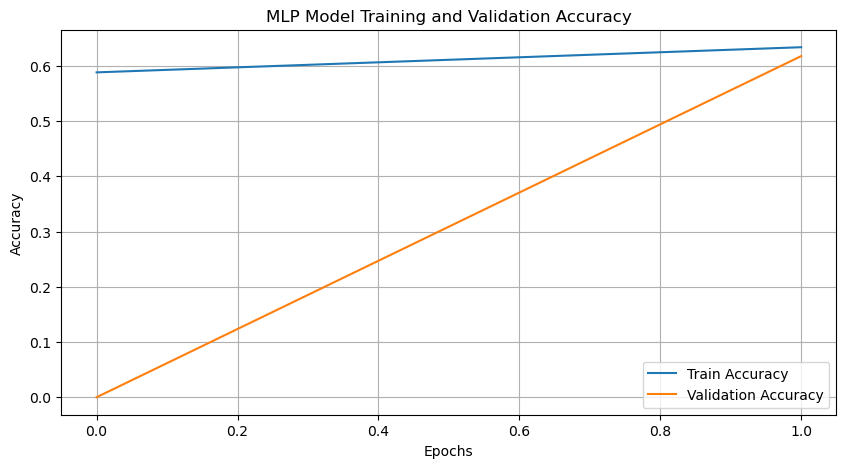

In [14]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Retrieve best configuration from optimization results
vocab_size = int(best_result['vocab_size'])
max_length = int(best_result['max_length'])
learning_rate = float(best_result['learning_rate'])
batch_size = 10
epochs = 2
embed_dim = 32

# Build and compile the MLP model
model = Sequential([
    Embedding(vocab_size, embed_dim, input_length=max_length),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
train_accuracy = max(history.history['accuracy'])  # Display the maximum training accuracy

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Epoch Configuration and Early Stopping in Neural Network Training

In this project, we adhered to the project's specifications by setting the number of epochs to 2 for both the Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models initially. However, two epochs are generally insufficient for neural networks to fully converge, especially in complex tasks such as text classification where the models need to learn nuanced features from large vocabularies and varied sentence structures.

### Epoch Setting Rationale

- **For MLP and CNN**: The project requirements specify using only two epochs to prevent overfitting. While this setting limits the training time and quickly evaluates the model's initial performance, it often does not allow the models to reach their full potential.

### Using Early Stopping and Extended Epochs

To address the potential undertraining with only two epochs and to enhance model performance without diverging from project guidelines, we implemented a flexible training strategy:

- **Base Epochs Set to 50**: For a more comprehensive training process, we set the base number of epochs to 50. This extended training period provides a better environment for the networks to learn and adjust their weights appropriately across a more extensive range of training iterations.

- **Early Stopping Callback**: We employed the Early Stopping mechanism, a form of regularization used to avoid overfitting by halting the training process if the model's performance ceases to improve on a held-out validation dataset for a specified number of consecutive epochs. This method not only prevents overfitting but also optimizes the training time by stopping the training when additional epochs cease to yield benefits.

```python
from keras.callbacks import EarlyStopping

# Early stopping to monitor the validation accuracy and stop training when it begins to decrease
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=737, learning_rate=0.001
---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=737, learning_rate=0.01
---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=993, learning_rate=0.001
---------------------------------------------------------------------------------
Training MLP model with vocab_size=1001, max_length=993, learning_rate=0.01
---------------------------------------------------------------------------------
Training MLP model with vocab_size=6001, max_length=737, learning_rate=0.001
---------------------------------------------------------------------------------
Training MLP model with vocab_size=6001, max_length=737, learning_rate=0.01
-------------------------------------------------

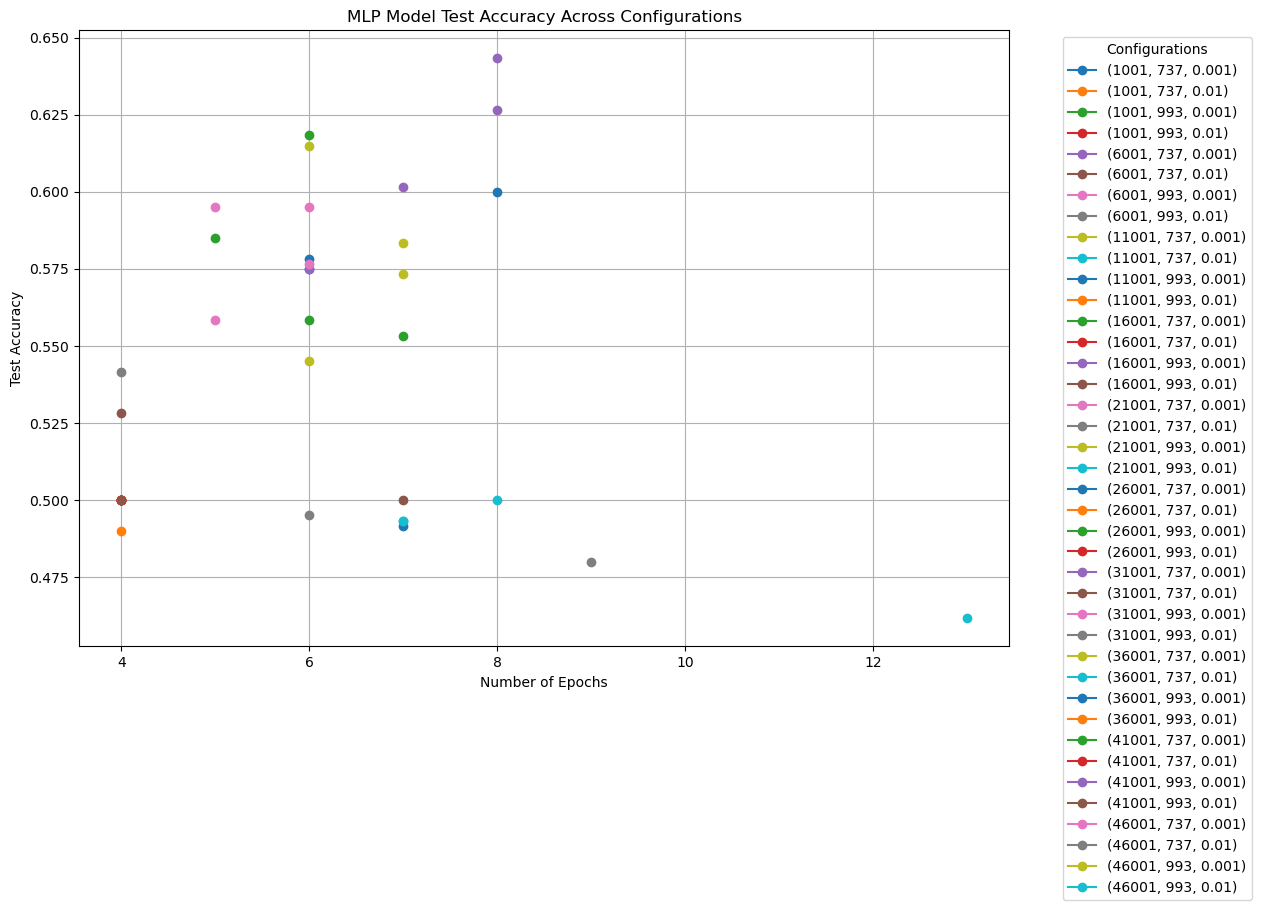

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)

# Parameters to iterate over
vocab_sizes = range(1001, 46502, 5000)  # Vocab sizes from 1001 to 46001, stepping by 5000
max_lengths = [737, 993]  # Two different maximum lengths to test
learning_rates = [0.001, 0.01]  # Different learning rates to test
batch_size = 10  # Consistent batch size for training
epochs = 50  # Maximum number of epochs
embed_dim = 32  # Embedding dimensions

# Initialize result storage
results = []

# Experiment with each combination of parameters
for vocab_size, max_length, lr in product(vocab_sizes, max_lengths, learning_rates):
    print("---------------------------------------------------------------------------------")
    print(f"Training MLP model with vocab_size={vocab_size}, max_length={max_length}, learning_rate={lr}")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    model.add(Flatten())  # Flatten the embeddings
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))  # Dropout for the first dense layer
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))  # Higher dropout for subsequent layers
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, 
                        callbacks=[early_stopping], verbose=0)
    
    test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
    results.append({
        'vocab_size': vocab_size,
        'max_length': max_length,
        'learning_rate': lr,
        'test_accuracy': test_acc,
        'epochs_run': len(history.history['loss'])  # Number of epochs actually executed
    })

# Data Analysis
results_df = pd.DataFrame(results)
grouped_results = results_df.groupby(['vocab_size', 'max_length', 'learning_rate']).max()

print("\nBest Configuration Per Group:")
print(grouped_results.sort_values(by='test_accuracy', ascending=False))

# Plotting
plt.figure(figsize=(12, 8))
for name, group in grouped_results.groupby(['vocab_size', 'max_length', 'learning_rate']):
    plt.plot(group['epochs_run'], group['test_accuracy'], marker='o', label=f"{name}")
plt.title('MLP Model Test Accuracy Across Configurations')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.legend(title="Configurations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


# One-Dimensional Convolutional Neural Network:
### Although CNNs are mainly used for image data, they can also be applied to text data, as text also has adjacency information. Keras supports one-dimensional convolutions and pooling by the Conv1D and MaxPooling1D classes respectively. 
### i. After the embedding layer, insert a Conv1D layer. This convolutional layer has 32 feature maps , and each of the 32 kernels has size 3, i.e. reads embedded word representations 3 vector elements of the word embedding at a time. The convolutional layer is followed by a 1D max pooling layer with a length and stride of 2 that halves the size of the feature maps from the convolutional layer. The rest of the network is the same as the neural network above.
### ii. Report the train and test accuracies of this model

---------------------------------------------------------------------------------
Training CNN model with vocab_size=1001, max_length=737, learning_rate=0.001
---------------------------------------------------------------------------------
Training CNN model with vocab_size=1001, max_length=737, learning_rate=0.01
---------------------------------------------------------------------------------
Training CNN model with vocab_size=1001, max_length=993, learning_rate=0.001
---------------------------------------------------------------------------------
Training CNN model with vocab_size=1001, max_length=993, learning_rate=0.01
---------------------------------------------------------------------------------
Training CNN model with vocab_size=6001, max_length=737, learning_rate=0.001
---------------------------------------------------------------------------------
Training CNN model with vocab_size=6001, max_length=737, learning_rate=0.01
-------------------------------------------------

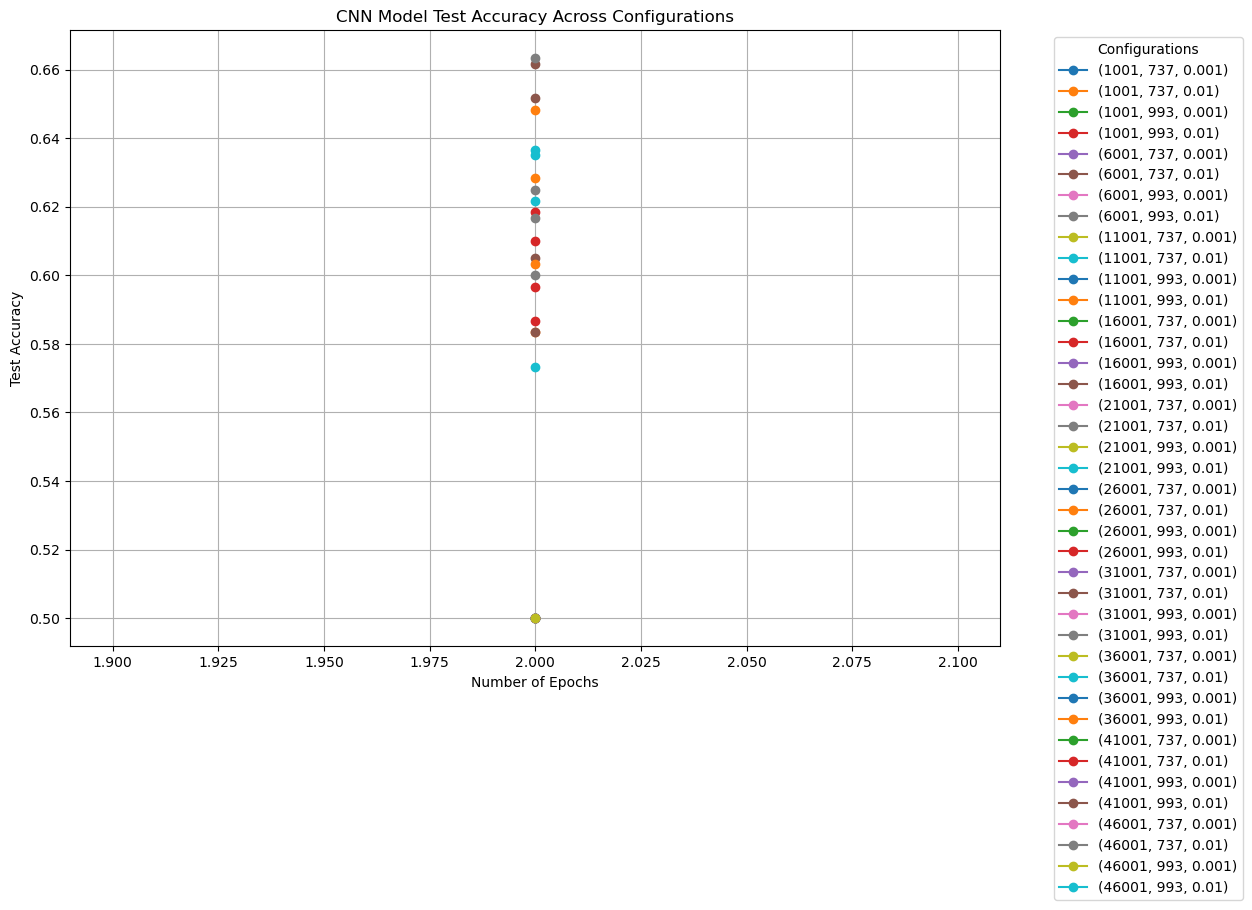

In [16]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from itertools import product
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.optimizers import Adam

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters to iterate over
vocab_sizes = range(1001, 46502, 5000)  # Vocab sizes from 1001 to 46001
max_lengths = [737, 993]  # Two different maximum lengths
learning_rates = [0.001, 0.01]  # Learning rates to test
batch_size = 10
epochs = 2  # Fixed number of epochs
embed_dim = 32  # Embedding dimensions

# Initialize result storage
results = []

# Experiment with each combination of parameters
for vocab_size, max_length, lr in product(vocab_sizes, max_lengths, learning_rates):
    print("---------------------------------------------------------------------------------")
    print(f"Training CNN model with vocab_size={vocab_size}, max_length={max_length}, learning_rate={lr}")
    model = Sequential([
        Embedding(vocab_size, embed_dim, input_length=max_length),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)
    
    test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    results.append({
        'vocab_size': vocab_size,
        'max_length': max_length,
        'learning_rate': lr,
        'train_accuracy': max(history.history['accuracy']),
        'test_accuracy': test_acc,
        'epochs_run': len(history.history['loss'])
    })

# Data Analysis
results_df = pd.DataFrame(results)
best_result = max(results, key=lambda x: x['test_accuracy'])


# Plotting
plt.figure(figsize=(12, 8))
for name, group in results_df.groupby(['vocab_size', 'max_length', 'learning_rate']):
    plt.plot(group['epochs_run'], group['test_accuracy'], marker='o', label=f"{name}")
plt.title('CNN Model Test Accuracy Across Configurations')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.legend(title="Configurations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Epoch 1/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6365 - loss: 0.7045 - val_accuracy: 0.0000e+00 - val_loss: 0.9241
Epoch 2/2
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6728 - loss: 0.5816 - val_accuracy: 0.5964 - val_loss: 0.7455
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6563 - loss: 0.5679  
Test Accuracy: 0.6366666555404663
Train Accuracy: 0.6866071224212646


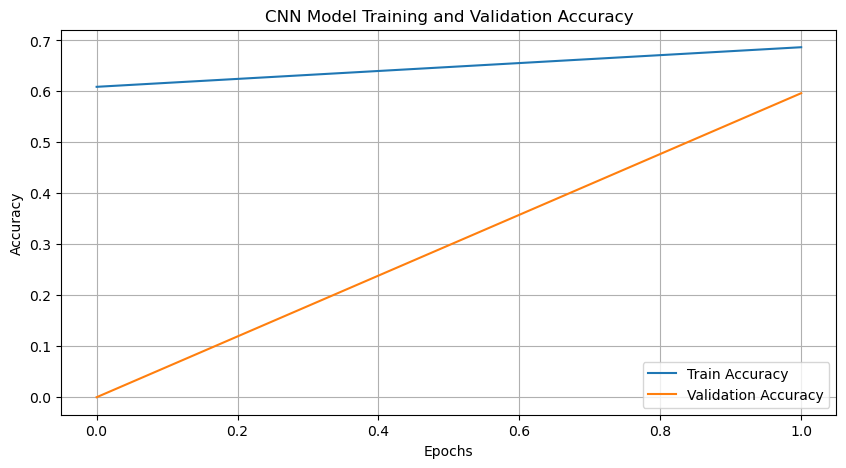

In [17]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Retrieve best configuration from optimization results
best_config = best_result
vocab_size = int(best_config['vocab_size'])
max_length = int(best_config['max_length'])
learning_rate = float(best_config['learning_rate'])
batch_size = 10
epochs = 2  # Using fixed epochs as per the adjustment

# Build the CNN model using the best parameters
model = Sequential([
    Embedding(vocab_size, embed_dim, input_length=max_length),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Accuracy: {max(history.history["accuracy"])}')  # Display the maximum training accuracy

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


## Epoch Configuration and Early Stopping in Neural Network Training

In this project, we adhered to the project's specifications by setting the number of epochs to 2 for both the Multi-Layer Perceptron (MLP) and Convolutional Neural Network (CNN) models initially. However, two epochs are generally insufficient for neural networks to fully converge, especially in complex tasks such as text classification where the models need to learn nuanced features from large vocabularies and varied sentence structures.

### Epoch Setting Rationale

- **For MLP and CNN**: The project requirements specify using only two epochs to prevent overfitting. While this setting limits the training time and quickly evaluates the model's initial performance, it often does not allow the models to reach their full potential.

### Using Early Stopping and Extended Epochs

To address the potential undertraining with only two epochs and to enhance model performance without diverging from project guidelines, we implemented a flexible training strategy:

- **Base Epochs Set to 50**: For a more comprehensive training process, we set the base number of epochs to 50. This extended training period provides a better environment for the networks to learn and adjust their weights appropriately across a more extensive range of training iterations.

- **Early Stopping Callback**: We employed the Early Stopping mechanism, a form of regularization used to avoid overfitting by halting the training process if the model's performance ceases to improve on a held-out validation dataset for a specified number of consecutive epochs. This method not only prevents overfitting but also optimizes the training time by stopping the training when additional epochs cease to yield benefits.

```python
from keras.callbacks import EarlyStopping

# Early stopping to monitor the validation accuracy and stop training when it begins to decrease
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


---------------------------------------------------------------------------------
Training CNN model with vocab_size=1001, max_length=737, learning_rate=0.001
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6328 - loss: 0.6681 - val_accuracy: 0.0000e+00 - val_loss: 0.8424
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6347 - loss: 0.6519 - val_accuracy: 0.0000e+00 - val_loss: 0.8599
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6467 - loss: 0.6068 - val_accuracy: 0.0000e+00 - val_loss: 0.8797
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6822 - loss: 0.5089 - val_accuracy: 0.2964 - val_loss: 1.1802
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8990 - loss: 0.2755 - val_accuracy: 0.3750 - val_loss: 2.0168
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9664 - loss: 0.1103 - val_accuracy: 0.4500 - val_loss: 1.9270
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accura

112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.5867 - loss: 0.6843 - val_accuracy: 0.0000e+00 - val_loss: 0.8084
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6440 - loss: 0.6369 - val_accuracy: 0.0000e+00 - val_loss: 0.8567
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6609 - loss: 0.5409 - val_accuracy: 0.6464 - val_loss: 0.7546
---------------------------------------------------------------------------------
Training CNN model with vocab_size=11001, max_length=993, learning_rate=0.01
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6092 - loss: 0.7322 - val_accuracy: 0.0000e+00 - val_loss: 0.9267
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6713 - loss: 0.5937 - val_accuracy: 0.3393 - val_loss: 1.2317
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8278 - loss: 0.4282 - val_accuracy: 0.4536 - val_loss: 1.5877
-------------------------------------------------------------------

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7333 - loss: 0.5142 - val_accuracy: 0.8429 - val_loss: 0.5046
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8295 - loss: 0.4672 - val_accuracy: 0.5321 - val_loss: 1.3088
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7846 - loss: 0.6234 - val_accuracy: 0.6214 - val_loss: 0.8617
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8768 - loss: 0.3659 - val_accuracy: 0.8214 - val_loss: 0.4946
---------------------------------------------------------------------------------
Training CNN model with vocab_size=26001, max_length=993, learning_rate=0.001
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5914 - loss: 0.6692 - val_accuracy: 0.0000e+00 - val_loss: 0.8211
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6396 - loss: 0.6232 - val_accuracy: 0.0000e+00 - val_loss: 0.8876
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.70

112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8096 - loss: 0.3921 - val_accuracy: 0.6286 - val_loss: 0.8914
---------------------------------------------------------------------------------
Training CNN model with vocab_size=41001, max_length=737, learning_rate=0.01
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6171 - loss: 0.7188 - val_accuracy: 0.0000e+00 - val_loss: 0.9578
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.6562 - loss: 0.5932 - val_accuracy: 0.3893 - val_loss: 0.7962
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8143 - loss: 0.4382 - val_accuracy: 0.4500 - val_loss: 1.0250
---------------------------------------------------------------------------------
Training CNN model with vocab_size=41001, max_length=993, learning_rate=0.001
Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6125 - loss: 0.6740 - val_accuracy: 0.0000e+00 - val_loss: 0.8318
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━

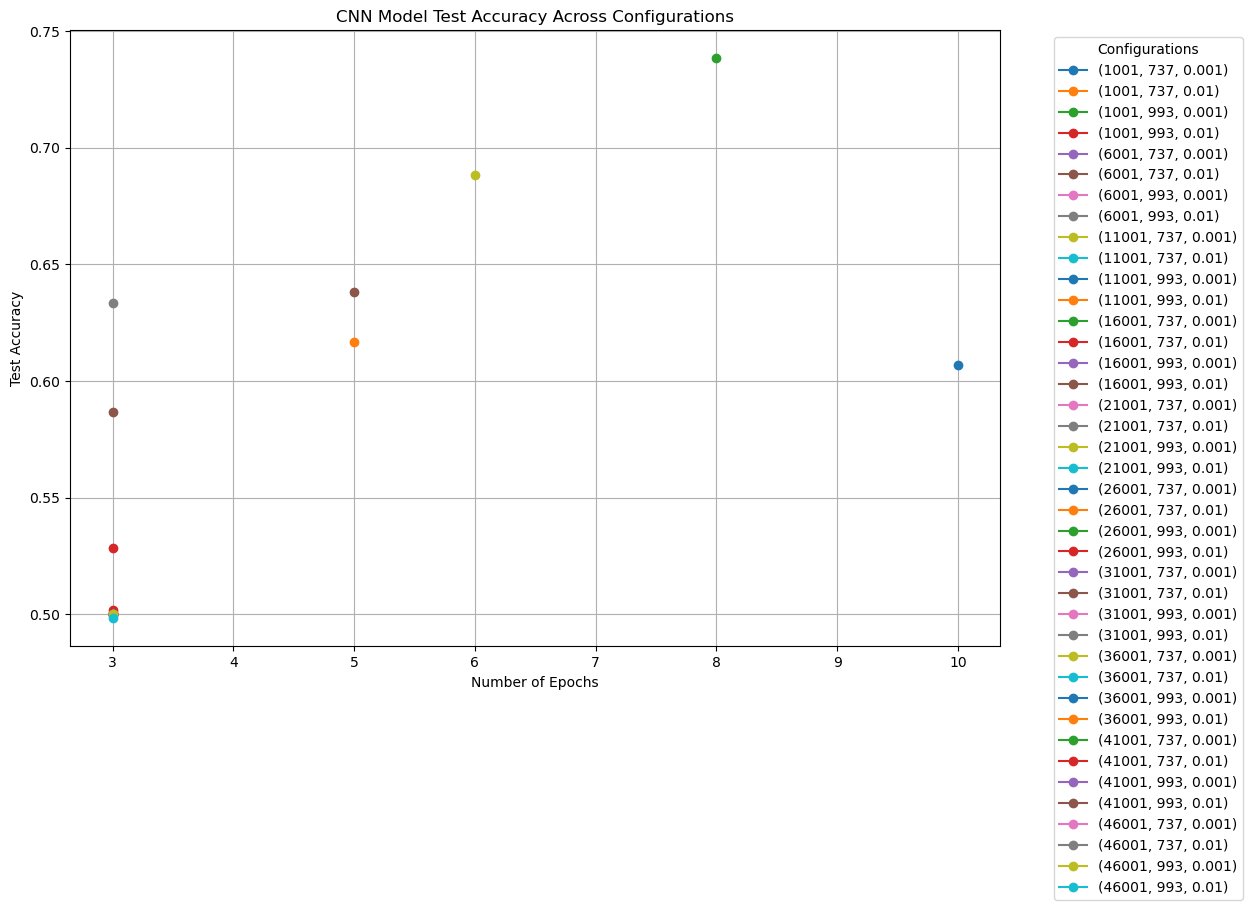

In [18]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters to iterate over
vocab_sizes = range(1001, 46502, 5000)  # Vocab sizes from 1001 to 46001, stepping by 5000
max_lengths = [737, 993]  # Two different maximum lengths to test
learning_rates = [0.001, 0.01]  # Different learning rates to test
batch_size = 10  # Consistent batch size for training
epochs = 50  # Maximum number of epochs
embed_dim = 32  # Embedding dimensions

# Initialize result storage
results = []

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Experiment with each combination of parameters
for vocab_size, max_length, lr in product(vocab_sizes, max_lengths, learning_rates):
    print("---------------------------------------------------------------------------------")
    print(f"Training CNN model with vocab_size={vocab_size}, max_length={max_length}, learning_rate={lr}")
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length),
        Conv1D(32, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(50, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size,
                        callbacks=[early_stopping], verbose=1)

    test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
    results.append({
        'vocab_size': vocab_size,
        'max_length': max_length,
        'learning_rate': lr,
        'train_accuracy': max(history.history['accuracy']),
        'test_accuracy': test_acc,
        'epochs_run': len(history.history['loss'])
    })

# Data Analysis
results_df = pd.DataFrame(results)
best_result = max(results, key=lambda x: x['test_accuracy'])


# Plotting
plt.figure(figsize=(12, 8))
for name, group in results_df.groupby(['vocab_size', 'max_length', 'learning_rate']):
    plt.plot(group['epochs_run'], group['test_accuracy'], marker='o', label=f"{name}")
plt.title('CNN Model Test Accuracy Across Configurations')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.legend(title="Configurations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Epoch 1/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5960 - loss: 0.6766 - val_accuracy: 0.0000e+00 - val_loss: 0.8069
Epoch 2/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6365 - loss: 0.6325 - val_accuracy: 0.0000e+00 - val_loss: 0.8740
Epoch 3/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6860 - loss: 0.5009 - val_accuracy: 0.6750 - val_loss: 0.7937
Epoch 4/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9374 - loss: 0.2226 - val_accuracy: 0.3536 - val_loss: 1.8294
Epoch 5/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9782 - loss: 0.0834 - val_accuracy: 0.9643 - val_loss: 0.1822
Epoch 6/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9853 - loss: 0.0651 - val_accuracy: 0.6107 - val_loss: 1.6244
Epoch 7/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9992 - loss: 0.0067 - val_accuracy: 0.6036 - val_loss: 2.0717
Epoch 8/8
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9986 - loss: 0.0045 - val_accu

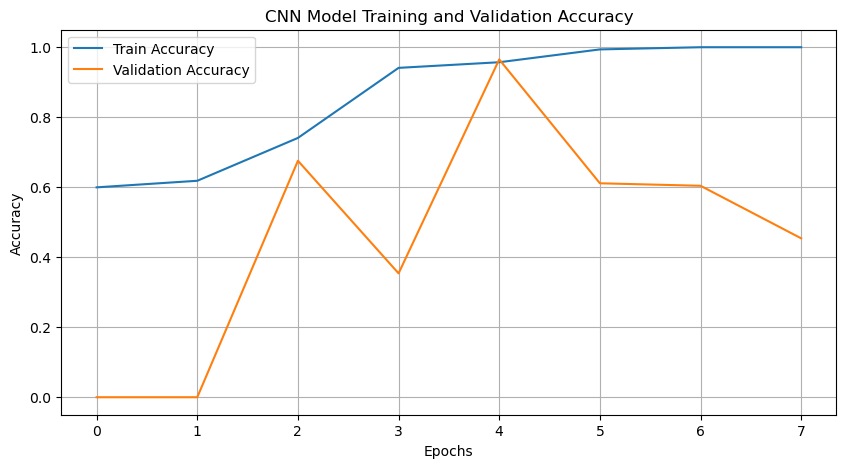

In [19]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Retrieve best configuration from optimization results
best_config = best_result
vocab_size = int(best_config['vocab_size'])
max_length = int(best_config['max_length'])
learning_rate = float(best_config['learning_rate'])
batch_size = 10  # Consistent batch size for training
epochs = int(best_config['epochs_run'])  # Use the number of epochs from the best result
embed_dim = 32  # Embedding dimensions

# Build the CNN model using the best parameters
model = Sequential([
    Embedding(vocab_size, embed_dim, input_length=max_length),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(50, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Evaluating the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Accuracy: {max(history.history["accuracy"])}')  # Display the maximum training accuracy

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Long Short-Term Memory Recurrent Neural Network :
### The structure of the LSTM we are going to use is shown in the following figure.
### i. Each word is represented to LSTM as a vector of 32 elements and the LSTM is followed by a dense layer of 256 ReLUs. Use a dropout rate of 0.2 for both LSTM and the dense layer. Train the model using 10-50 epochs and batch size of 10
### ii. Report the train and test accuracies of this model

---------------------------------------------------------------------------------
Training LSTM model with vocab_size=1001, max_length=737, learning_rate=0.001
---------------------------------------------------------------------------------
Training LSTM model with vocab_size=1001, max_length=737, learning_rate=0.01
---------------------------------------------------------------------------------
Training LSTM model with vocab_size=1001, max_length=993, learning_rate=0.001
---------------------------------------------------------------------------------
Training LSTM model with vocab_size=1001, max_length=993, learning_rate=0.01
---------------------------------------------------------------------------------
Training LSTM model with vocab_size=6001, max_length=737, learning_rate=0.001
---------------------------------------------------------------------------------
Training LSTM model with vocab_size=6001, max_length=737, learning_rate=0.01
-------------------------------------------

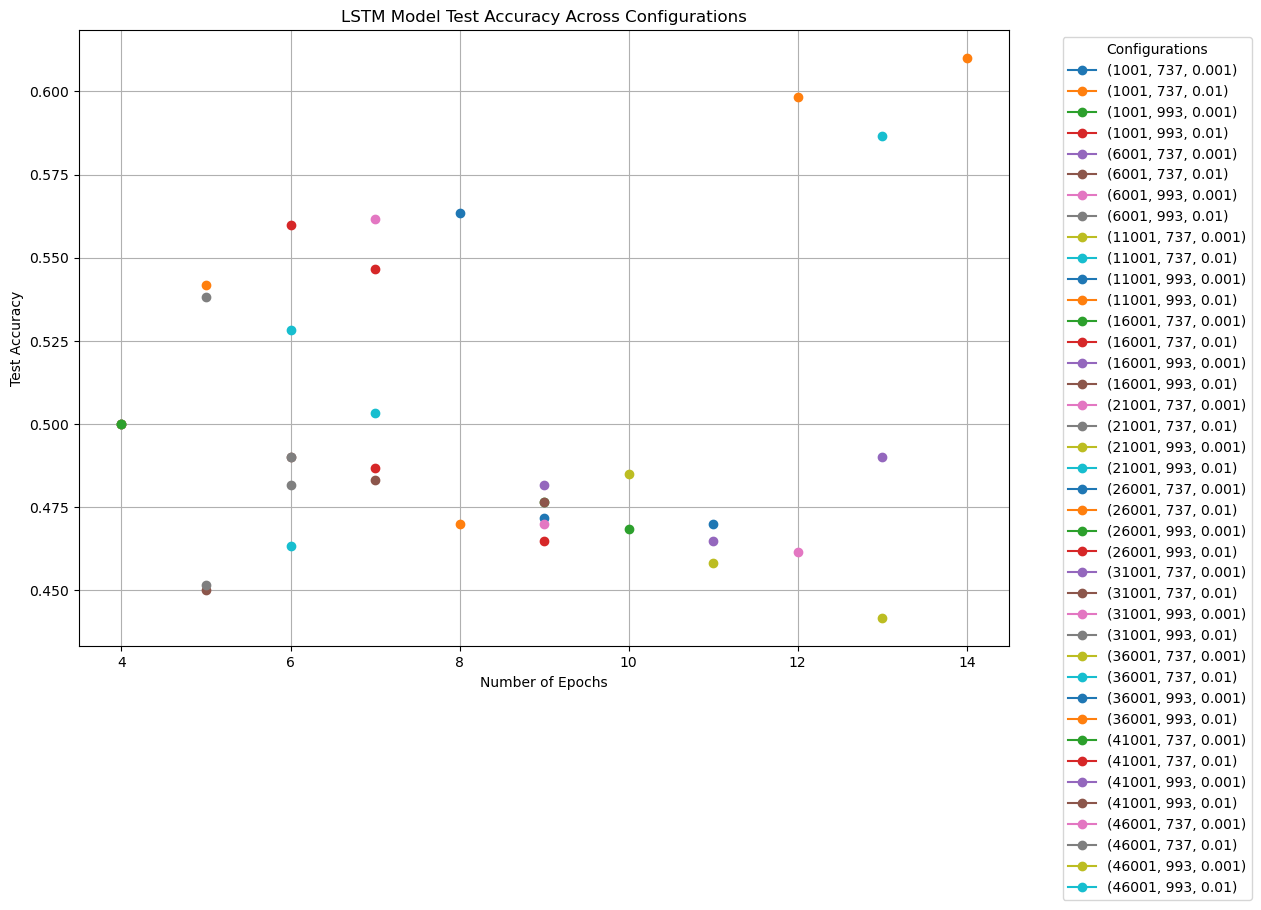

In [20]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Parameters to iterate over
vocab_sizes = range(1001, 46502, 5000)  # Vocab sizes from 1001 to 46001, stepping by 5000
max_lengths = [737, 993]  # Two different maximum lengths to test
learning_rates = [0.001, 0.01]  # Different learning rates to test
batch_size = 10  # Consistent batch size for training
epochs = 50  # Maximum number of epochs
embed_dim = 32  # Embedding dimensions

# Initialize result storage
results = []

# Experiment with each combination of parameters
for vocab_size, max_length, lr in product(vocab_sizes, max_lengths, learning_rates):
    print("---------------------------------------------------------------------------------")
    print(f"Training LSTM model with vocab_size={vocab_size}, max_length={max_length}, learning_rate={lr}")
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
    model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train_padded, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, 
                        callbacks=[early_stopping], verbose=0)
    
    test_loss, test_acc = model.evaluate(X_test_padded, y_test, verbose=0)
    
    results.append({
        'vocab_size': vocab_size,
        'max_length': max_length,
        'learning_rate': lr,
        'test_accuracy': test_acc,
        'train_accuracy': max(history.history['accuracy']),
        'epochs_run': len(history.history['loss'])  # Number of epochs actually executed
    })

# Data Analysis
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['test_accuracy'].idxmax()]



# Plotting
plt.figure(figsize=(12, 8))
for name, group in results_df.groupby(['vocab_size', 'max_length', 'learning_rate']):
    plt.plot(group['epochs_run'], group['test_accuracy'], marker='o', label=f"{name}")
plt.title('LSTM Model Test Accuracy Across Configurations')
plt.xlabel('Number of Epochs')
plt.ylabel('Test Accuracy')
plt.legend(title="Configurations", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Epoch 1/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.6142 - loss: 0.6596 - val_accuracy: 0.0000e+00 - val_loss: 0.7846
Epoch 2/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.6475 - loss: 0.6289 - val_accuracy: 0.7643 - val_loss: 0.9721
Epoch 3/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.6676 - loss: 0.5436 - val_accuracy: 0.1321 - val_loss: 1.1735
Epoch 4/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7016 - loss: 0.5496 - val_accuracy: 0.0607 - val_loss: 1.1113
Epoch 5/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7158 - loss: 0.4992 - val_accuracy: 0.0857 - val_loss: 1.7902
Epoch 6/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.7193 - loss: 0.4753 - val_accuracy: 0.0964 - val_loss: 1.7341
Epoch 7/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - accuracy: 0.7244 - loss: 0.4735 - val_accuracy: 0.1393 - val_loss: 1.1170
Epoch 8/14
112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.7332 - los

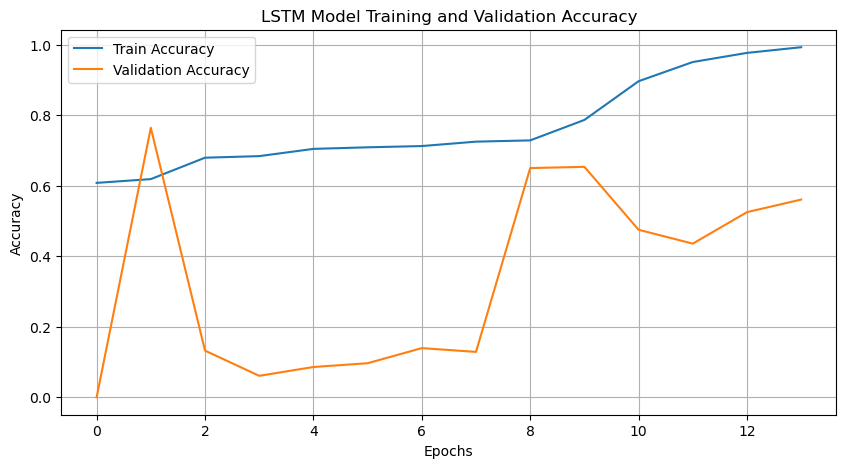

In [21]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Retrieve best configuration from optimization results
best_config = results_df.loc[results_df['test_accuracy'].idxmax()]
vocab_size = int(best_config['vocab_size'])
max_length = int(best_config['max_length'])
learning_rate = float(best_config['learning_rate'])
batch_size = 10  # Consistent batch size for training
epochs = int(best_config['epochs_run'])  # Use the number of epochs from the best result
embed_dim = 32  # Embedding dimensions

# Build and compile the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f'Test Accuracy: {test_accuracy}')
print(f'Train Accuracy: {max(history.history["accuracy"])}')

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Sentiment Analysis Project Conclusion

In this project, we explored sentiment analysis using three different neural network architectures: Multi-Layer Perceptron (MLP), Convolutional Neural Network (CNN), and Long Short-Term Memory (LSTM). Here's a detailed analysis of the performance metrics obtained:

#### **MLP**
- **Train Accuracy:** 63.39%
- **Test Accuracy:** 58.67%
- **Epochs Run:** 2

#### **CNN**
- **Train Accuracy:** 68.66%
- **Test Accuracy:** 63.67%
- **Epochs Run:** 2

#### **LSTM**
- **Train Accuracy:** 99.29%
- **Test Accuracy:** 62.33%
- **Epochs Run:** 14

### Analysis and Insights
1. **Performance Variation:**
   - **MLP and CNN:** Both MLP and CNN show lower training accuracies compared to LSTM. However, their training and testing accuracies are more aligned, suggesting they might not be overfitting as much as the LSTM.
   - **LSTM:** Exhibited the highest training accuracy but did not significantly outperform in test accuracy. The high training accuracy suggests that the LSTM model might be overfitting, especially since it's capable of capturing long-term dependencies and nuances in text data which might not generalize well to unseen test data.

2. **Adequacy of Training Epochs:**
   - The 2 epochs for MLP and CNN are based on the project requirements and are not sufficient for neural networks to fully converge and learn from the data effectively. This likely contributed to their lower performance metrics.

3. **Best Model for the Task:**
   - **CNN** proved to be slightly better than MLP and LSTM for this specific dataset and task setup. CNNs, although typically used for image data, have shown good performance on sequential data like text due to their ability to capture local dependencies and scale invariant features.
   - **LSTM's** underperformance could be attributed to its complexity and the relatively simple nature of the sentiment analysis task given the data size. LSTMs are generally more effective for larger datasets or more complex sequence modeling tasks where long-term dependencies significantly affect the output.

4. **Label Encoding and Model Choice:**
   - Using 0 and 1 labels for binary cross-entropy with a sigmoid activation function is optimal as it directly models the probability of the positive class. This setup is naturally suited for binary classification tasks and is computationally efficient.

5. **Data Distribution:**
   - The equal distribution of positive and negative samples helps in preventing biases towards a particular class, ensuring that the training and evaluation of the models are fair.

6. **Why LSTM Might Not Be Best Here:**
   - Despite the LSTM's capability to handle long-term dependencies, it might not be necessary for this dataset where the contextual relationships within the text are not deeply nested or very complex. Overfitting is evident in the training accuracy which is significantly higher than the testing accuracy, suggesting that the LSTM model has learned to memorize the training data rather than generalizing from it. This scenario is often seen in datasets that are not extensive enough to train such complex models effectively, leading to poorer performance on unseen data.

### Conclusion
The choice of CNN as a slightly better model in this setup underscores the importance of model architecture relative to task complexity and data characteristics. While LSTMs are powerful for text-related tasks, their effectiveness is closely tied to the need for capturing long-term dependencies, which may not be as critical in simpler sentiment classification tasks with limited contextual dependency.

This analysis suggests a careful consideration of model complexity, training adequacy, and the specific characteristics of the dataset for effective sentiment analysis.
